<a href="https://colab.research.google.com/github/K-Wolfe-hub/spds_capstone_3/blob/main/spds_capstone_3_post_model_valid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The intetion of this notebook is to evaluate the ability for the model created based on westmoreland Co. PA data to predict in a different landscape. In this case we are going to use wells locations from Sweetwater Co. WY. and then random locations from a non-oil and gas producing area of the contry.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
#from the PADEP I downloaded the header information for the oil and gas wells for West Finley township within Washington Co. PA. https://newdata-padep-1.opendata.arcgis.com/datasets/oil-gas-locations-conventional/explore
import pandas as pd
sweet = pd.read_excel('gdrive/My Drive/Springboard_Capstone_3/Sweetwater_Wells.xlsx')
sweet.head(1)

,Apino,Wellname,County,Company,Field_Name,Horiz_Dir,Sec,Twp,T_Dir,Rge,R_Dir,Qtr1,Qtr2,Lat,Lon,Well_class,land_type,bsec,btwp,bt_dir,brge,br_dir,blat,blon,status,Statusdate,CoalBed,Rcvd_Date
0,3705000,LOST SOLDIER UNIT #2,37,AMPLIFY ENERGY OPERATING LLC,LOST SOLDIER,N,3,26,N,90,W,NE,,42.248268,-107.562416,I,10,0.0,0.0,N,0.0,W,0.0,0.0,AI,19860314.0,N,NaT


##Only run this code once. pulls the image files from EE.

In [19]:
#installing geemap
!pip install geemap


     |████████████████████████████████| 476 kB 2.8 MB/s 
     |████████████████████████████████| 1.2 MB 48.5 MB/s 
     |████████████████████████████████| 219 kB 57.7 MB/s 
     |████████████████████████████████| 1.6 MB 27.4 MB/s 
     |████████████████████████████████| 3.3 MB 57.9 MB/s 
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 130 kB 53.7 MB/s 
     |████████████████████████████████| 98 kB 6.6 MB/s 
     |████████████████████████████████| 1.3 MB 53.1 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 76 kB 5.2 MB/s 
     |████████████████████████████████| 97 kB 5.2 MB/s 
     |████████████████████████████████| 70 kB 4.4 MB/s 
     |████████████████████████████████| 393 kB 66.0 MB/s 
     |████████████████████████████████| 112 kB 53.9 MB/s 
     |████████████████████████████████| 553 kB 49.7 MB/s 
     |████████████████████████████████| 428 kB 47.5 MB/s 
     |█████████████████████

In [20]:
import ee
import geemap
#establishing connection to Earth Engine (ee) from Colab requires an authorization from my gmail account. ee documentation shows how to do this.
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=w6TkREddvaEEew5kRkNhCwmpuPoXxGsN8Q6dTstkpVc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhU5HllWBoDfvyH5do4pWfDjix4YuQiy9qakFktx-CsoINhC8rD5MQ

Successfully saved authorization token.


In [5]:
#Built by modifying the instructions from https://geemap.org/notebooks/11_export_image/ to better match this dataset.
#This code will iterate through the dataset of wells, selecting each well's API# and location and use this data to pull the 250 cells surrounding the suposed wellhead from the NAIP data
'''for i in range(len(sweet)):
  lon = float(sweet.iloc[i].Lon)
  lat = float(sweet.iloc[i].Lat)
  api = str(sweet.iloc[i].Apino)
  loc = ee.Geometry.Point((lon,lat))
  locbuf= loc.buffer(distance=250)
  roi = locbuf.coordinates()
  roi_ee = ee.Geometry.Polygon(roi)
  collection = ee.ImageCollection('USDA/NAIP/DOQQ').filterBounds(loc).filterDate('2019-01-01', '2020-12-31')
  img = collection.first()
  geemap.ee_export_image_to_drive(img, description=api, folder='sweet250', region=roi_ee)'''


"for i in range(len(sweet)):\n  lon = float(sweet.iloc[i].Lon)\n  lat = float(sweet.iloc[i].Lat)\n  api = str(sweet.iloc[i].Apino)\n  loc = ee.Geometry.Point((lon,lat))\n  locbuf= loc.buffer(distance=250)\n  roi = locbuf.coordinates()\n  roi_ee = ee.Geometry.Polygon(roi)\n  collection = ee.ImageCollection('USDA/NAIP/DOQQ').filterBounds(loc).filterDate('2019-01-01', '2020-12-31')\n  img = collection.first()\n  geemap.ee_export_image_to_drive(img, description=api, folder='sweet250', region=roi_ee)"

##Gooding, ID area data creation

In [6]:
#define an area in Idaho where there are no oil and gas wells to pull images to see how the model does.
gooding_lat = 42.937527
gooding_lon = -114.712875
sweet_lat_rng = sweet.Lat.max()-sweet.Lat.min()
sweet_lon_rng = sweet.Lon.max()-sweet.Lon.min()
lat1 = gooding_lat+sweet_lat_rng/2
lat2 = gooding_lat-sweet_lat_rng/2
lon1 = gooding_lon+sweet_lon_rng/2
lon2 = gooding_lon-sweet_lon_rng/2
print(str(lat1)+', '+str(lon1))
print(str(lat2)+', '+str(lon2))

43.5678135, -113.4467945
42.307240500000006, -115.9789555


In [8]:
#Creates a grid of point to pull images from geemap in this new area
gooding = pd.DataFrame(columns=['api','lat','lon'])
for i in range(100):
  templat = lat1-(sweet_lat_rng/100*i)
  for j in range(83):
    templon = lon1-(sweet_lon_rng/83*j)
    gooding = gooding.append({'api':'loc'+str(i)+'_'+str(j),'lat':templat,'lon':templon}, ignore_index=True)
print(gooding.shape)
gooding.head()

(8300, 3)


,api,lat,lon
0,loc0_0,43.567813,-113.446794
1,loc0_1,43.567813,-113.477302
2,loc0_2,43.567813,-113.507810
3,loc0_3,43.567813,-113.538318
4,loc0_4,43.567813,-113.568826


In [21]:
#Built by modifying the instructions from https://geemap.org/notebooks/11_export_image/ to better match this dataset.
#This code will iterate through the dataset of wells, selecting each well's API# and location and use this data to pull the 250 cells surrounding the suposed wellhead from the NAIP data
'''for i in range(len(gooding)):
  lon = float(gooding.iloc[i].lon)
  lat = float(gooding.iloc[i].lat)
  api = str(gooding.iloc[i].api)
  loc = ee.Geometry.Point((lon,lat))
  locbuf= loc.buffer(distance=250)
  roi = locbuf.coordinates()
  roi_ee = ee.Geometry.Polygon(roi)
  collection = ee.ImageCollection('USDA/NAIP/DOQQ').filterBounds(loc).filterDate('2019-01-01', '2020-12-31')
  img = collection.first()
  geemap.ee_export_image_to_drive(img, description=api, folder='gooding250', region=roi_ee)'''

Streaming output truncated to the last 5000 lines.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too many tasks already in the queue (3000). Please wait for some of them to complete.
Too

##load the Sweetwater Co. data into a numpy array for prediction

In [7]:
import cv2 as cv
sweet['path'] = 'gdrive/My Drive/sweet250/'+sweet['Apino'].map(str)+'.tif'
sweet.dropna(axis=0,subset=['path'],inplace=True)


In [9]:
sweet.shape

(8305, 29)

In [32]:
import os
sweet_imgs = []
for i in range(len(sweet)):
  if os.path.isfile(sweet.iloc[i].path):
    sweet_imgs.append(cv.resize(cv.cvtColor(cv.imread(sweet.iloc[i].path), cv.COLOR_BGR2RGB),(85,84),interpolation= cv.INTER_LINEAR))
  else:
    pass

In [33]:
import numpy as np
sweet_np = np.asarray(sweet_imgs)

##Load final model from modeling step

In [2]:
from tensorflow.keras.models import load_model
model = load_model('gdrive/My Drive/Springboard_Capstone_3/simpleConv2D')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 82, 83, 8)         224       
_________________________________________________________________
flatten (Flatten)            (None, 54448)             0         
_________________________________________________________________
dropout (Dropout)            (None, 54448)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 54449     
Total params: 54,673
Trainable params: 54,673
Non-trainable params: 0
_________________________________________________________________


##Predict Sweetwater Co. locations

In [34]:
sweetpred = model.predict(sweet_np)
sweetpred_map = np.round(sweetpred)

In [35]:
sweetpred_map[0:5]

array([[1.],
       [1.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [36]:
sweetpred_map.sum()/len(sweetpred_map)

0.7540301612064483

This model is flagging about 25% of the locations as not having a well pad. This is way more than would be expected for 

In [37]:
present = []
for i in range(len(sweet)):
  present.append(os.path.isfile(sweet.iloc[i].path))

In [38]:
sweet['present'] = present

In [39]:
testdf = sweet[sweet['present']]

In [40]:
testdf['predict'] = sweetpred_map
testdf.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Apino,Wellname,County,Company,Field_Name,Horiz_Dir,Sec,Twp,T_Dir,Rge,R_Dir,Qtr1,Qtr2,Lat,Lon,Well_class,land_type,bsec,btwp,bt_dir,brge,br_dir,blat,blon,status,Statusdate,CoalBed,Rcvd_Date,path,present,predict
0,3705000,LOST SOLDIER UNIT #2,37,AMPLIFY ENERGY OPERATING LLC,LOST SOLDIER,N,3,26,N,90,W,NE,,42.248268,-107.562416,I,10,0.0,0.0,N,0.0,W,0.0,0.0,AI,19860314.0,N,NaT,gdrive/My Drive/sweet250/3705000.tif,True,1.0
1,3705001,GOVT 48,37,BAIR OIL COMPANY,LOST SOLDIER,N,3,26,N,90,W,SW,SE,42.250321,-107.580024,G,11,0.0,0.0,N,0.0,W,0.0,0.0,PA,19230702.0,N,NaT,gdrive/My Drive/sweet250/3705001.tif,True,1.0


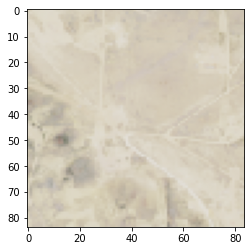

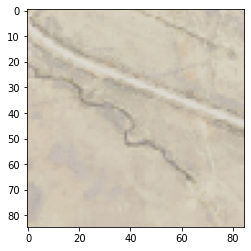

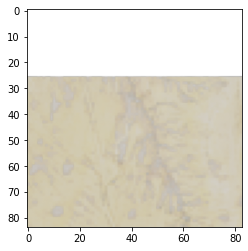

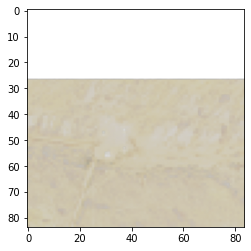

In [45]:
import matplotlib.pyplot as plt
for i in range(4):
  plt.imshow(plt.imread(nvis['path'].iloc[i]))
  plt.show()

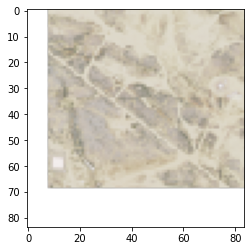

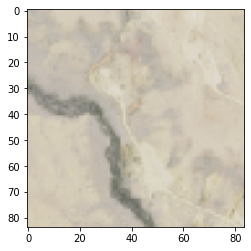

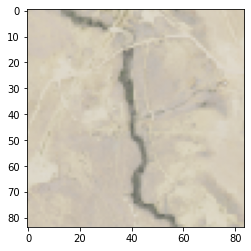

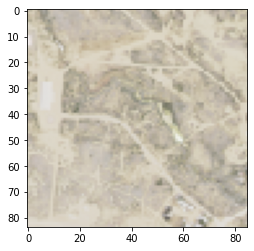

In [46]:
vis = testdf[testdf['predict']==1]
for i in range(4):
  plt.imshow(plt.imread(vis['path'].iloc[i]))
  plt.show()

##Load Idaho locations all with no well.

In [9]:
import cv2 as cv
gooding['path'] = 'gdrive/My Drive/gooding250/'+gooding['api'].map(str)+'.tif'
gooding.dropna(axis=0,subset=['path'],inplace=True)

In [10]:
import os
import numpy as np
gooding_imgs = []
for i in range(len(gooding)):
  if os.path.isfile(gooding.iloc[i].path):
    gooding_imgs.append(cv.resize(cv.cvtColor(cv.imread(gooding.iloc[i].path), cv.COLOR_BGR2RGB),(85,84),interpolation= cv.INTER_LINEAR))
  else:
    pass
gooding_np = np.asarray(gooding_imgs)


In [11]:
goodingpred = model.predict(gooding_np)
goodingpred_map = np.round(goodingpred)

In [12]:
goodingpred_map.sum()/len(goodingpred_map)

0.7560363750391973

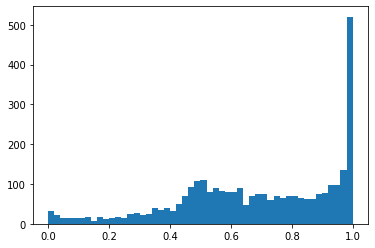

In [15]:
plt.hist(x=goodingpred,bins=50)
plt.show()

The model does a very bad with this dataset. It is predicting 85% of the random locations that I selected were predicted to have a well location (this should have been closer to 0%).

prediction: [1.]


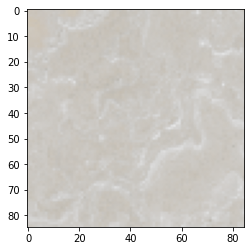

prediction: [1.]


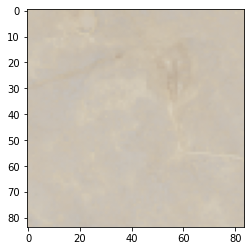

prediction: [0.]


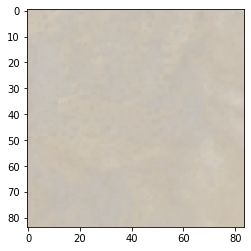

prediction: [0.]


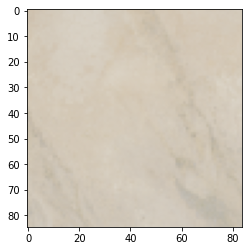

prediction: [0.]


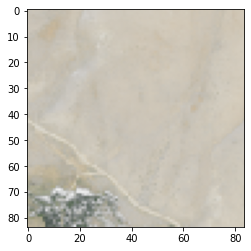

prediction: [1.]


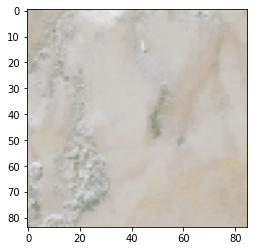

prediction: [1.]


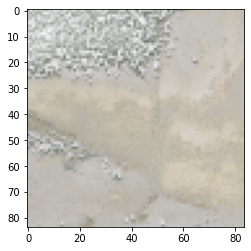

prediction: [0.]


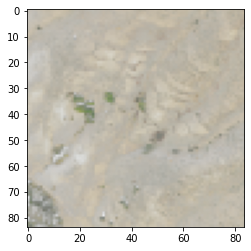

In [14]:
import matplotlib.pyplot as plt

for i in range(8):
  print('prediction: '+str(goodingpred_map[i]))
  plt.imshow(plt.imread(gooding['path'].iloc[i]))
  plt.show()